In [1]:
import sys
sys.path.append('../')

%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import cv2
from skimage.io import imread

from gen.load_data import load_data
from gen.generators import preprocess_label
from keras.models import Model, load_model


/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
train_df, valid_df, test_df = load_data('../data')
test_df.head()

,image,id,label
0,../data/Test/CameraRGB/00019.png,00019,../data/Test/CameraSeg/00019.png
1,../data/Test/CameraRGB/00413.png,00413,../data/Test/CameraSeg/00413.png
2,../data/Test/CameraRGB/00035.png,00035,../data/Test/CameraSeg/00035.png
3,../data/Test/CameraRGB/00264.png,00264,../data/Test/CameraSeg/00264.png
4,../data/Test/CameraRGB/00172.png,00172,../data/Test/CameraSeg/00172.png


In [5]:
from models.segnet import model_segnetVGG16
from models.segnet import model_segnet
from models.segnet_custom_layers import MaxPoolingWithArgmax2D, MaxUnpooling2D


from train import jaccard_distance_loss

model = load_model('../saved_models/segnet_extended/segnetExt.h5', 
                   {'MaxPoolingWithArgmax2D': MaxPoolingWithArgmax2D,
                    'MaxUnpooling2D' : MaxUnpooling2D
                   })


/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


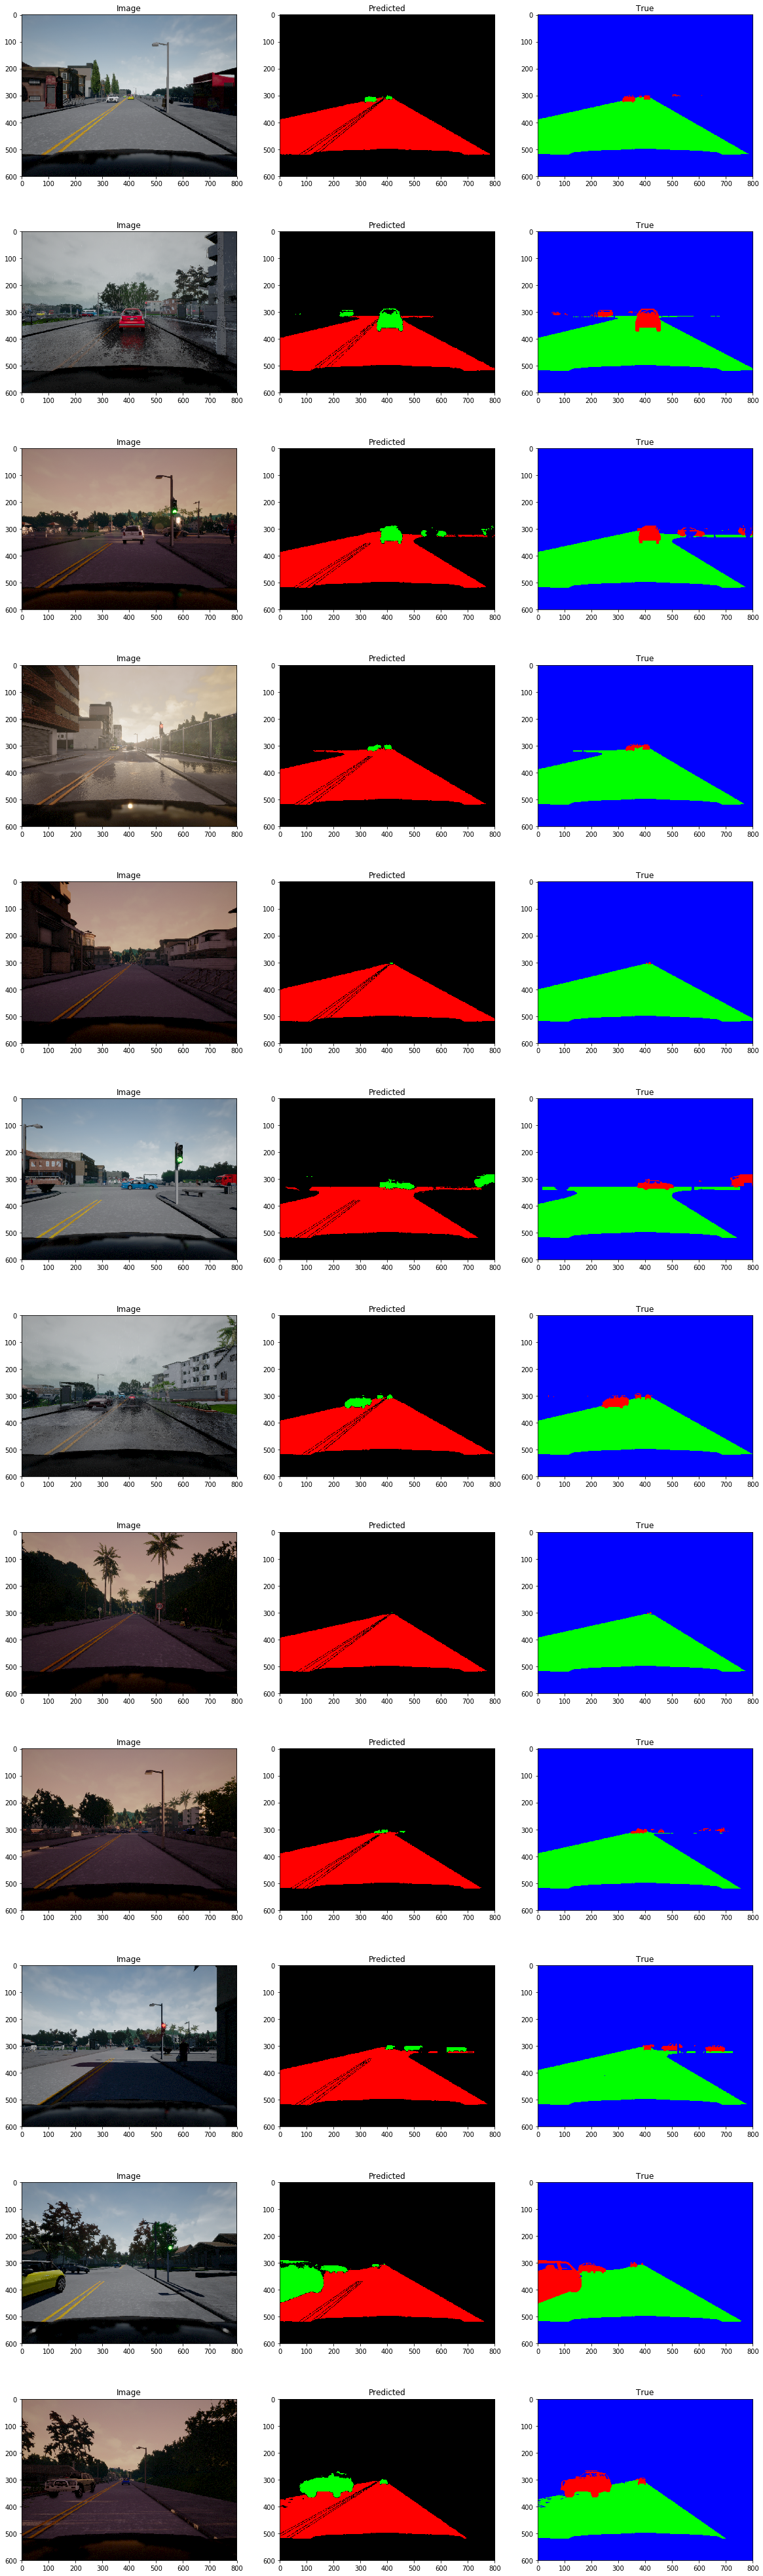

In [7]:
from keras.applications.vgg16 import preprocess_input

sample_rows = 12
fig, m_axs = plt.subplots(sample_rows, 3, figsize = (20, 6*sample_rows))
for (ax1, ax2, ax3), (_, c_row) in zip(m_axs, train_df.sample(sample_rows).iterrows()):
    c_img = imread(c_row['image']).astype(np.float64)
    r_rgb_img = imread(c_row['image'])
    c_img = preprocess_input(c_img)
    p_img = model.predict(np.expand_dims(cv2.resize(c_img, (384, 384)), 0))[0]
    p_img = p_img.argmax(axis=2)
        
    binary_car_result = cv2.resize((p_img == 0).astype(np.uint8), (800, 600))
    binary_road_result = cv2.resize((p_img == 1).astype(np.uint8), (800, 600))
    output_lbl = np.zeros((600, 800, 3))
    output_lbl[:, :, 0] = binary_road_result
    output_lbl[:, : , 1] = binary_car_result
    
    l_img = imread(c_row['label'])
    l_img = preprocess_label(l_img)
    
    ax1.imshow(r_rgb_img)
    ax1.set_title('Image')    
    ax2.imshow(output_lbl)
    ax2.set_title('Predicted')
    ax3.imshow(l_img*255)
    ax3.set_title('True')